# **Steel Defect Detection**
Group number: **124**

Anushri Bhansali - ambhansa

Jay Patel - jhpatel9

Shail Shah - sshah38

### **PLEASE READ: This is part 1/2 of submission. This file contains base approach of Unet, Unet++ and EfficientNet as a backbone in Unet. The part 2/2 is present in the zip file which contains fine tuned Unet which as extra efforts.**

## ProjF5 - Baseline Model


## 1. Loading and Preparing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### 1.1 Importing required Libraries and Modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
from tqdm import tqdm
from time import sleep
import os
import tensorflow as tf

In [ ]:
import os
import gc
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

### 1.2 Driver path to access the dataset

In [ ]:
path = '/content/drive/MyDrive/NN_PROJECT/severstal-steel-defect-detection/'
train = pd.read_csv(path + 'train.csv')
# test = pd.read_csv(path + 'test.csv')
images = pd.DataFrame({'ImageId': os.listdir(path+'train_images')})

In [ ]:
# train.csv
train2 = pd.merge(train, images, how='right').sort_values('ImageId')
train2 = train2.reset_index(drop=True)


train2 = train2.pivot(index=['ImageId'], columns=['ClassId'], values=['EncodedPixels'])
train2 = train2.reset_index()

train2 = train2.groupby('ImageId').sum().reset_index()
train2.columns = ['ImageId', ' ', 'e1', 'e2', 'e3', 'e4']
train2 = train2.drop(' ', axis=1)

train2['count'] = train2.apply(lambda x: 4-x.value_counts()[0], axis=1)
train2.head()

,ImageId,e1,e2,e3,e4,count
0,008479d08.jpg,0,0,0,0,0
1,008ef3d74.jpg,356336 4 356587 11 356838 18 357089 25 357340 ...,375439 5 375687 14 375935 24 376182 34 376430 ...,0,0,2
2,00d639396.jpg,0,0,229356 17 229595 34 229850 36 230105 37 230360...,0,1
3,01053d28f.jpg,43063 3 43319 8 43575 13 43831 18 44087 23 443...,0,0,0,1
4,012a9a4c7.jpg,176752 4 176996 17 177251 19 177506 21 177761 ...,0,0,0,1


### 2. Preparing Final Model

### 2.1 Creating rle masks on images

In [ ]:
def rle2mask(rle):
    if rle==0:
        return np.zeros((128, 800), dtype=np.uint8)

    height = 256
    width = 1600
    # rle
    mask = np.zeros(width*height, dtype=np.uint8)

    starts_lengths = np.asarray([int(x) for x in rle.split()])
    starts = starts_lengths[0::2]-1
    lengths = starts_lengths[1::2]
    for idx, start in enumerate(starts):
        mask[int(start): int(start+lengths[idx])] = 1

    # order='F'
    return mask.reshape((height, width), order='F')[::2, ::2]

def mask2contour(mask, width=3):
    w = mask.shape[1]
    h = mask.shape[0]

    # mask
    mask2 = np.concatenate([mask[:, width:], np.zeros((h, width))], axis=1)
    mask2 = np.logical_xor(mask, mask2)
    mask3 = np.concatenate([mask[width:, :], np.zeros((width, w))], axis=0)
    mask3 = np.logical_xor(mask, mask3)

    return np.logical_or(mask2, mask3)

def mask_padding(mask, pad=2):

    w = mask.shape[1]
    h = mask.shape[0]


    for i in range(1, pad, 2):
        temp = np.concatenate([mask[i:, :], np.zeros((i, w))], axis=0)
        mask = np.logical_or(mask, temp)

    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((i, w)), mask[:-i, :]], axis=0)
        mask = np.logical_or(mask, temp)

    for i in range(1, pad, 2):
        temp = np.concatenate([mask[:, i:], np.zeros((h, i))], axis=1)
        mask = np.logical_or(mask, temp)

    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((h, i)), mask[:, :-i]], axis=1)
        mask = np.logical_or(mask, temp)

    return mask


def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### 2.2 Creating DataLoader classes

In [ ]:

# https://minimin2.tistory.com/100

class DataLoader(tf.keras.utils.Sequence):

    def __init__(self, x, y, batch_size=16, shuffle=False):
        super().__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle


    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)


    def __getitem__(self, idx):

        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
#         batch_x = []
#         batch_y = []
#         for i in indices:
#             batch_x.append(self.x[i])
#             batch_y.append(self.y[i])

        return np.array(batch_x), np.array(batch_y)

    # epoch
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:

class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=16, subset='train', shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size

        if self.subset == 'train':
            self.data_path = path + 'train_images/'
        elif self.subset == 'test':
            self.data_path = path + 'test_images/'
        self.on_epoch_end()


    def __len__(self):
        return math.ceil(len(self.df)/self.batch_size)

    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, 128, 800, 3), dtype=np.float32)
        Y = np.zeros((self.batch_size, 128, 800, 4), dtype=np.int8)
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        for i, f in enumerate(self.df['ImageId'].iloc[indices]):
            X[i] = Image.open(self.data_path + f).resize((800, 128))
            if self.subset == 'train':
                for j in range(4):
                    Y[i, ..., j] = rle2mask(self.df['e'+str(j+1)].iloc[indices[i]])

        if self.subset == 'train':
            return X, Y
        else:
            return X

    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

defect1: red, defect2: green, defect3: yellow, defect4: purple


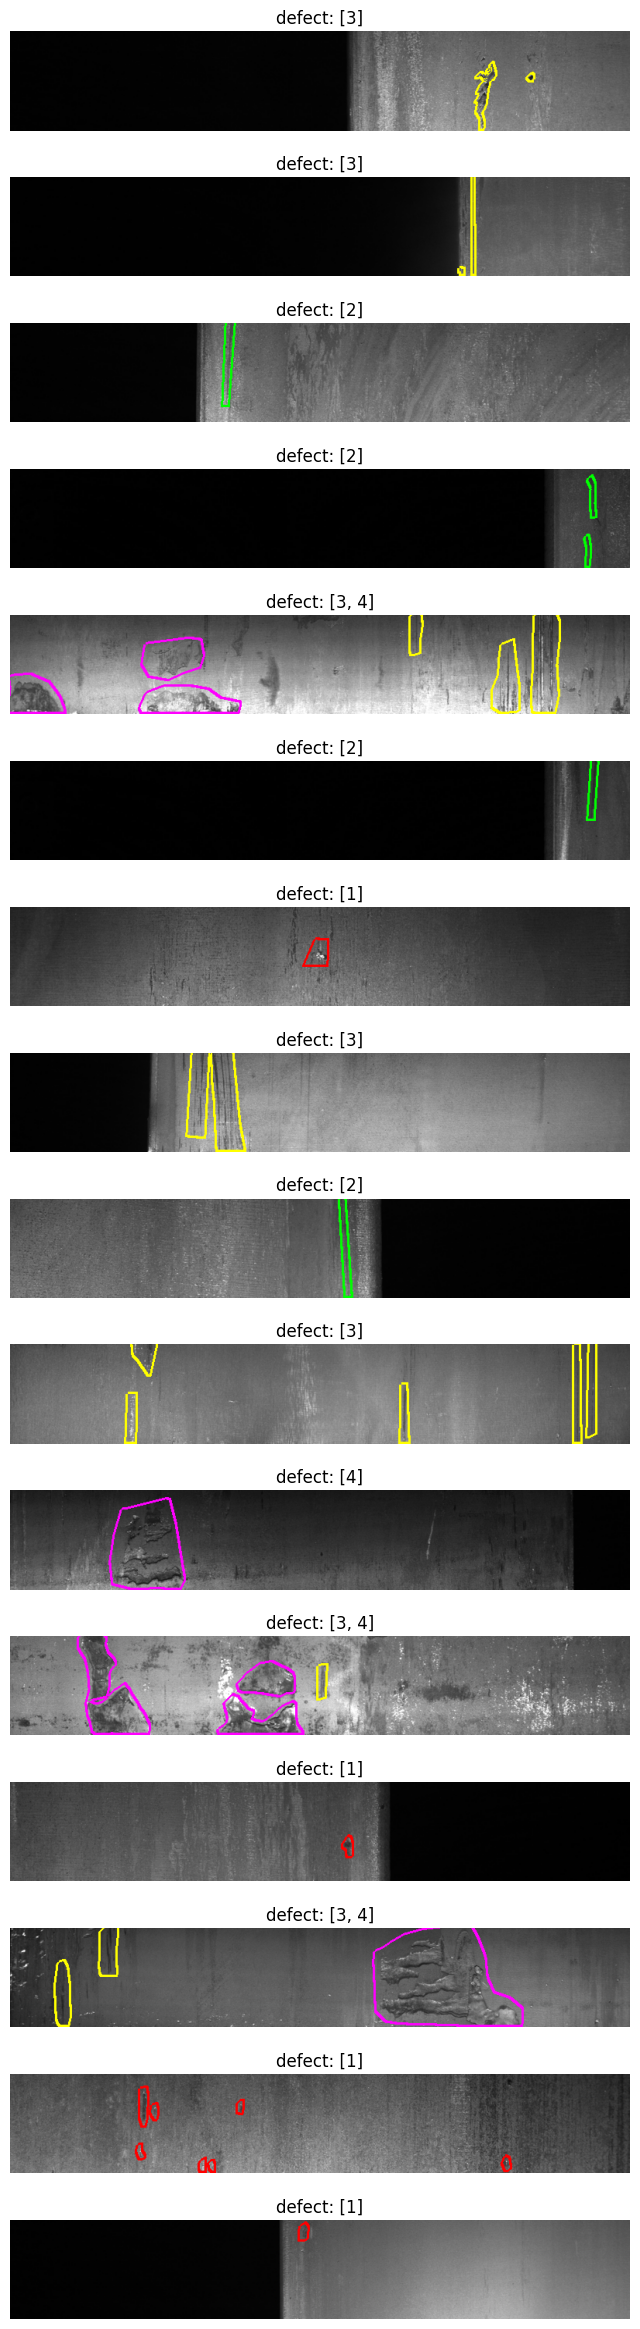

In [ ]:
from math import *
import math

defects = list(train2[train2['e1']!=0].sample(4).index)
defects += list(train2[train2['e2']!=0].sample(4).index)
defects += list(train2[train2['e3']!=0].sample(4).index)
defects += list(train2[train2['e4']!=0].sample(4).index)


train_batches = DataLoader(train2[train2.index.isin(defects)], shuffle=True)
print('defect1: red, defect2: green, defect3: yellow, defect4: purple')

plt.figure(figsize=(8, 30))
for batch in train_batches:
    for i in range(16):
        plt.subplot(16, 1, i+1)
        img = batch[0][i]/255
        defect = []

        for j in range(4):
            msk = batch[1][i, ..., j]
            msk = mask_padding(msk)
            msk = mask2contour(msk)
            if np.sum(msk) != 0:
                defect.append(j+1)
            if j == 0:
                img[msk==1] = 1, 0, 0
            elif j == 1:
                img[msk==1] = 0, 1, 0
            elif j == 2:
                img[msk==1] = 1, 1, 0
            elif j == 3:
                img[msk==1] = 1, 0, 1

        plt.title(f'defect: {defect}')
        plt.axis('off')
        plt.imshow(img)
    plt.show()

### 2.3 **Approach 1/4: UNet**

In [ ]:


def get_model(input_shape, init_node, classify):
    out_dim = init_node

    input_ = tf.keras.Input(shape=input_shape)

    # Contracting Path
    conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(input_)
    conv1_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv1)
    conv2 = layers.MaxPool2D()(conv1_out)

    out_dim *= 2
    conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv2)
    conv2_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv2)
    conv3 = layers.MaxPool2D()(conv2_out)

    out_dim *= 2
    conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv3)
    conv3_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv3)
    conv4 = layers.MaxPool2D()(conv3_out)

    out_dim *= 2
    conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv4)
    conv4_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv4)
    conv5 = layers.MaxPool2D()(conv4_out)

    # Mid
    out_dim *= 2
    conv_mid = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv5)
    conv_mid = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv_mid)

    # Expansive Path
    out_dim /= 2
    t_conv1 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(conv_mid)
    t_conv1 = layers.Concatenate()([conv4_out, t_conv1])
    t_conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv1)
    t_conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv1)

    out_dim /= 2
    t_conv2 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv1)
    t_conv2 = layers.Concatenate()([conv3_out, t_conv2])
    t_conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv2)
    t_conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv2)

    out_dim /= 2
    t_conv3 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv2)
    t_conv3 = layers.Concatenate()([conv2_out, t_conv3])
    t_conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv3)
    t_conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv3)

    out_dim /= 2
    t_conv4 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv3)
    t_conv4 = layers.Concatenate()([conv1_out, t_conv4])
    t_conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv4)
    t_conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv4)

    output = layers.Conv2D(classify, 1, padding='same', activation='sigmoid')(t_conv4)

    model = tf.keras.Model(inputs=[input_], outputs=[output])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=dice_coef)

    return model

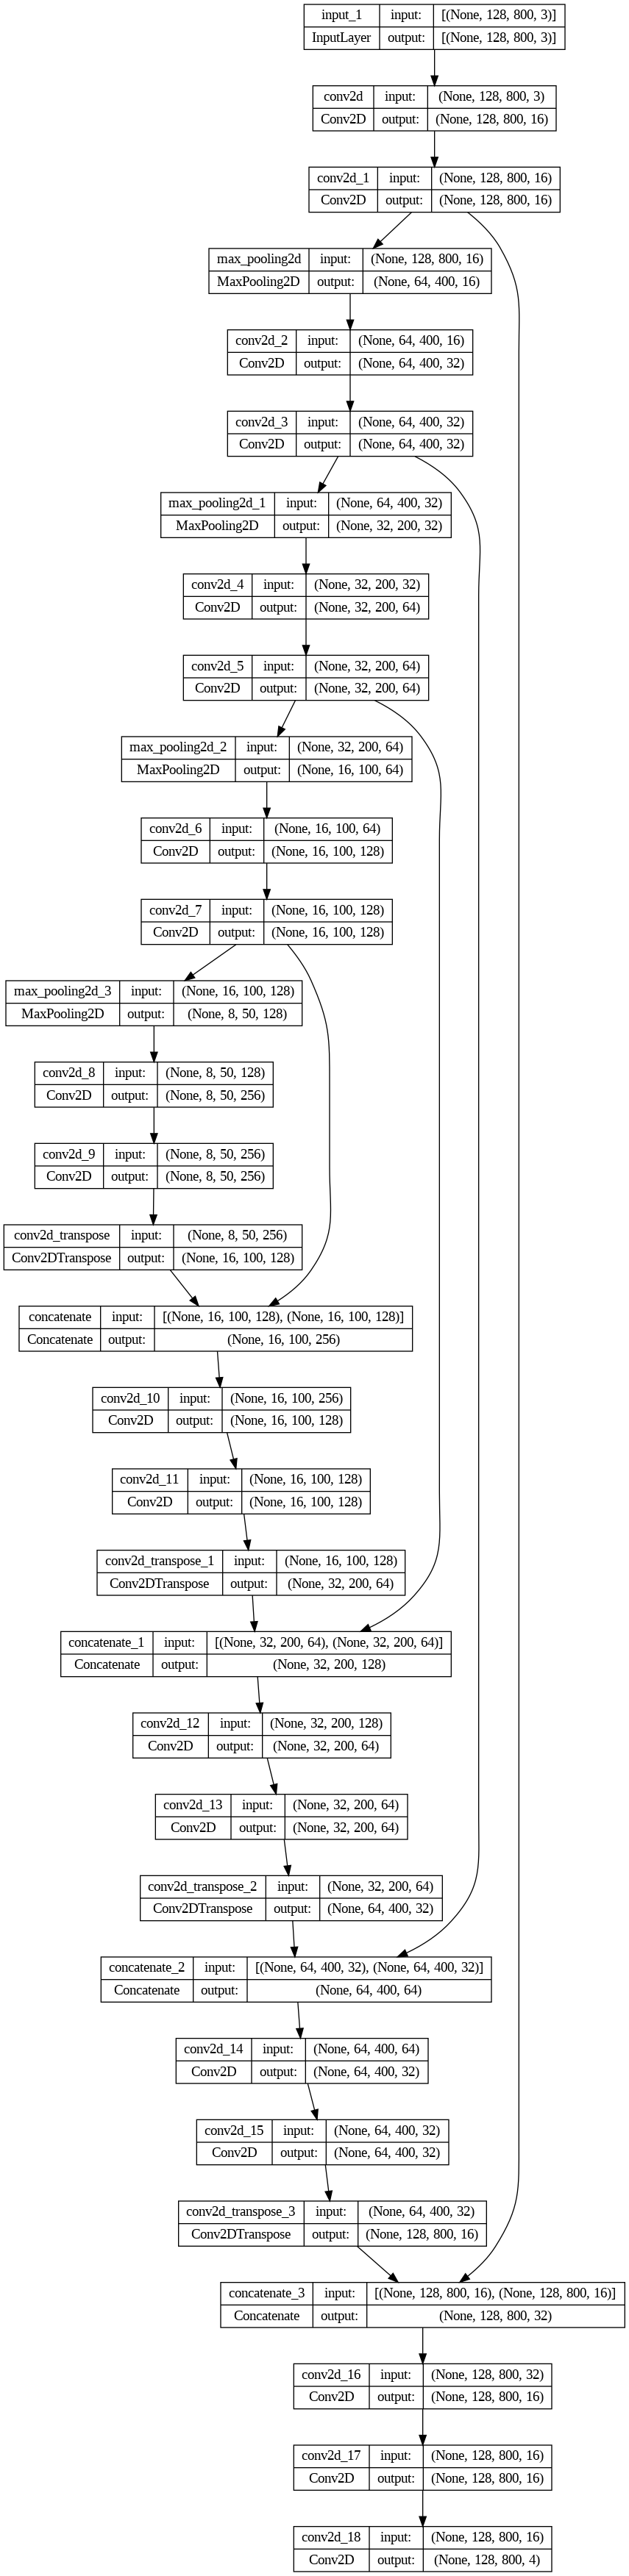

In [ ]:
import tensorflow as tf
from tensorflow import keras
tf.keras.backend.clear_session()
model_unet = get_model((128, 800, 3), 16, 4)
tf.keras.utils.plot_model(model_unet, show_shapes=True)

In [ ]:

train_idx = int(0.8*len(train2))
train_loader = DataLoader(train2.iloc[:train_idx], shuffle=True)
valid_loader = DataLoader(train2.iloc[train_idx:])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('defect_segmentation.hdf5',
                                                   monitor='val_dice_coef',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    monitor='val_dice_coef',
                                                    mode='max')

history = model_unet.fit_generator(train_loader,
                              validation_data=valid_loader,
                              epochs=50,
                              callbacks=[checkpoint_cb, earlystopping_cb])


Epoch 1/50
35/35 [==============================] - 36s 367ms/step - loss: 0.8090 - dice_coef: 0.0062 - val_loss: 0.1588 - val_dice_coef: 0.0100
Epoch 2/50
35/35 [==============================] - 14s 385ms/step - loss: 0.1205 - dice_coef: 0.0084 - val_loss: 0.1266 - val_dice_coef: 0.0015
Epoch 3/50
35/35 [==============================] - 14s 391ms/step - loss: 0.0537 - dice_coef: 0.0240 - val_loss: 0.0477 - val_dice_coef: 0.0266
Epoch 4/50
35/35 [==============================] - 13s 357ms/step - loss: 0.0406 - dice_coef: 0.0415 - val_loss: 0.0390 - val_dice_coef: 0.0653
Epoch 5/50
35/35 [==============================] - 13s 355ms/step - loss: 0.0385 - dice_coef: 0.0543 - val_loss: 0.0374 - val_dice_coef: 0.0503
Epoch 6/50
35/35 [==============================] - 12s 352ms/step - loss: 0.0358 - dice_coef: 0.0575 - val_loss: 0.0368 - val_dice_coef: 0.0693
Epoch 7/50
35/35 [==============================] - 22s 628ms/step - loss: 0.0356 - dice_coef: 0.0656 - val_loss: 0.0351 - val_dic

In [ ]:
model_unet.save('model_unet.h5')

In [ ]:
import tensorflow as tf

# Check if TensorFlow is using GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
predictions_unet = model_unet.predict(valid_loader)

9/9 [==============================] - 4s 453ms/step


In [ ]:
predictions_unet.shape

(144, 128, 800, 4)

In [ ]:
valid_loader

### 2.4 **Approach 2/4: UNET++**

In [ ]:
def conv_block(inputs, out_dim):
    conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(inputs)
    conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv1)
    return conv2

def upsample_concat(inputs, skip_inputs, out_dim):
    upsample = layers.UpSampling2D()(inputs)
    concat = layers.Concatenate()([upsample, skip_inputs])
    conv = conv_block(concat, out_dim)
    return conv

def unet_plusplus(input_shape, init_node, classify):
    out_dim = init_node

    input_ = tf.keras.Input(shape=input_shape)

    # Contracting Path
    conv1 = conv_block(input_, out_dim)
    conv1_out = conv_block(conv1, out_dim)
    conv2 = layers.MaxPool2D()(conv1_out)

    out_dim *= 2
    conv2 = conv_block(conv2, out_dim)
    conv2_out = conv_block(conv2, out_dim)
    conv3 = layers.MaxPool2D()(conv2_out)

    out_dim *= 2
    conv3 = conv_block(conv3, out_dim)
    conv3_out = conv_block(conv3, out_dim)
    conv4 = layers.MaxPool2D()(conv3_out)

    out_dim *= 2
    conv4 = conv_block(conv4, out_dim)
    conv4_out = conv_block(conv4, out_dim)
    conv5 = layers.MaxPool2D()(conv4_out)

    # U-Net++ Paths
    up_conv4 = upsample_concat(conv5, conv4_out, out_dim)
    up_conv3 = upsample_concat(up_conv4, conv3_out, out_dim)
    up_conv2 = upsample_concat(up_conv3, conv2_out, out_dim)
    up_conv1 = upsample_concat(up_conv2, conv1_out, out_dim)

    # Output
    output = layers.Conv2D(classify, 1, padding='same', activation='sigmoid')(up_conv1)

    model = tf.keras.Model(inputs=[input_], outputs=[output])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=dice_coef)

    return model


In [ ]:
# Create U-Net++ model
model_unetpp = unet_plusplus((128, 800, 3), 16, 4)

# Split the dataset
train_idx = int(0.8 * len(train2))
train_loader = DataLoader(train2.iloc[:train_idx], shuffle=True)
valid_loader = DataLoader(train2.iloc[train_idx:])

# Define callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('unetpp_segmentation.hdf5',
                                                   monitor='val_dice_coef',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    monitor='val_dice_coef',
                                                    mode='max')

# Train the model
history_unetpp = model_unetpp.fit(train_loader,
                                  validation_data=valid_loader,
                                  epochs=50,
                                  callbacks=[checkpoint_cb, earlystopping_cb])


Epoch 1/50
35/35 [==============================] - 72s 964ms/step - loss: 0.1100 - dice_coef: 0.0204 - val_loss: 0.0492 - val_dice_coef: 0.0098
Epoch 2/50
35/35 [==============================] - 33s 941ms/step - loss: 0.0367 - dice_coef: 0.0491 - val_loss: 0.0353 - val_dice_coef: 0.0835
Epoch 3/50
35/35 [==============================] - 33s 936ms/step - loss: 0.0340 - dice_coef: 0.0678 - val_loss: 0.0350 - val_dice_coef: 0.0857
Epoch 4/50
35/35 [==============================] - 33s 941ms/step - loss: 0.0330 - dice_coef: 0.0825 - val_loss: 0.0354 - val_dice_coef: 0.0629
Epoch 5/50
35/35 [==============================] - 33s 935ms/step - loss: 0.0312 - dice_coef: 0.1037 - val_loss: 0.0329 - val_dice_coef: 0.0844
Epoch 6/50
35/35 [==============================] - 33s 953ms/step - loss: 0.0317 - dice_coef: 0.1188 - val_loss: 0.0347 - val_dice_coef: 0.1579
Epoch 7/50
35/35 [==============================] - 33s 941ms/step - loss: 0.0300 - dice_coef: 0.1411 - val_loss: 0.0321 - val_dic

In [ ]:
model_unetpp.save('model_unetpp.h5')

### 2.5 **Appraoch 3/4: EfficientNet as the backbone**

In [ ]:
# Modify the upsampling path in your efficient_unet function
from tensorflow.keras.applications import EfficientNetB7
def efficient_unet(input_shape, init_node, classify):
    out_dim = init_node

    # Define input tensor
    print("heree")
    input_ = tf.keras.Input(shape=input_shape)
    # Use EfficientNetB7 as the backbone
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

    # Use the output of a specific layer in EfficientNet as the starting point
    start_layer = 300  # Example layer number to start with
    base_output = base_model.layers[start_layer].output

    # Upsampling layers
    up_conv1 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(base_output)
    up_conv1 = layers.Concatenate()([up_conv1, base_model.layers[200].output])
    up_conv2 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(up_conv1)
    up_conv2 = layers.Concatenate()([up_conv2, base_model.layers[100].output])
    up_conv3 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(up_conv2)
    up_conv3 = layers.Concatenate()([up_conv3, base_model.layers[50].output])
    up_conv4 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(up_conv3)
    up_conv4 = layers.Concatenate()([up_conv4, base_model.layers[25].output])

    # Output
    output = layers.Conv2D(classify, 1, padding='same', activation='sigmoid')(up_conv4)

    # Create the model
    model = tf.keras.Model(inputs=[input_], outputs=[output])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[dice_coef])

    return model

# Debugging steps
# 1. Check the shapes of tensors you're trying to concatenate
# 2. Modify the concatenation to match the shapes

# Example shapes with a specific batch size (e.g., 1)
shape1 = (1, 32, 200, 16)
shape2 = (1, 1, 1, 288)

# Check shapes
print(f'Shape 1: {shape1}, Shape 2: {shape2}')

# Create example tensors with these shapes
tensor1 = np.random.randn(*shape1)
tensor2 = np.random.randn(*shape2)

# Modify the concatenation to match the shapes
new_shape2 = (1, 32, 200, 16)
tensor2_resized = tf.image.resize(tensor2, (32, 200))
concatenated = layers.Concatenate()([tensor1, tensor2_resized])
print(f'Modified concatenation to match shapes: {tensor1.shape} and {tensor2_resized.shape}')



Shape 1: (1, 32, 200, 16), Shape 2: (1, 1, 1, 288)
Modified concatenation to match shapes: (1, 32, 200, 16) and (1, 32, 200, 288)


In [ ]:
model_efficientNet = get_model((128, 800, 3), 16, 4)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('defect_segmentation.hdf5',
                                                   monitor='val_dice_coef',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    monitor='val_dice_coef',
                                                    mode='max')
model_efficientNet.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[dice_coef])

# 3. Prepare Data
train_idx = int(0.8 * len(train2))
train_loader = DataLoader(train2.iloc[:train_idx], shuffle=True)
valid_loader = DataLoader(train2.iloc[train_idx:])

# 4. Train the Model
history_efficientNet = model_efficientNet.fit(train_loader,
                    validation_data=valid_loader,
                    epochs=50,
                    callbacks=[checkpoint_cb, earlystopping_cb])

Epoch 1/50
35/35 [==============================] - 23s 384ms/step - loss: 0.5832 - dice_coef: 0.0090 - val_loss: 0.1666 - val_dice_coef: 0.0096
Epoch 2/50
35/35 [==============================] - 15s 422ms/step - loss: 0.1533 - dice_coef: 0.0070 - val_loss: 0.1430 - val_dice_coef: 0.0122
Epoch 3/50
35/35 [==============================] - 15s 418ms/step - loss: 0.1133 - dice_coef: 0.0126 - val_loss: 0.1216 - val_dice_coef: 0.0196
Epoch 4/50
35/35 [==============================] - 14s 388ms/step - loss: 0.0617 - dice_coef: 0.0187 - val_loss: 0.0553 - val_dice_coef: 0.0248
Epoch 5/50
35/35 [==============================] - 13s 376ms/step - loss: 0.0554 - dice_coef: 0.0238 - val_loss: 0.0543 - val_dice_coef: 0.0231
Epoch 6/50
35/35 [==============================] - 13s 371ms/step - loss: 0.0534 - dice_coef: 0.0225 - val_loss: 0.0530 - val_dice_coef: 0.0298
Epoch 7/50
35/35 [==============================] - 18s 499ms/step - loss: 0.0522 - dice_coef: 0.0251 - val_loss: 0.0523 - val_dic

In [ ]:
model_efficientNet.save('model_efficientNet.h5')

## 3. Model Performance

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

### 3.1 Prediction on Training and Testing data with all 3 models

In [ ]:
import tensorflow as tf

# Load the saved models
model_efficientNet = tf.keras.models.load_model("/content/drive/MyDrive/NN_PROJECT/model_efficientNet.h5", custom_objects={'dice_coef': dice_coef})
model_unet = tf.keras.models.load_model("/content/drive/MyDrive/NN_PROJECT/model_unet.h5", custom_objects={'dice_coef': dice_coef})
model_unetpp = tf.keras.models.load_model("/content/drive/MyDrive/NN_PROJECT/model_unetpp.h5", custom_objects={'dice_coef': dice_coef})

# Assuming you have some test data X_test on which you want to make predictions
# Replace X_test with your actual test data
train_idx = int(0.8*len(train2))
train_loader = DataLoader(train2.iloc[:train_idx], shuffle=True)
valid_loader = DataLoader(train2.iloc[train_idx:])
X_test = valid_loader

# Perform predictions using each model
predictions_efficientNet = model_efficientNet.predict(X_test)
predictions_unet = model_unet.predict(X_test)
predictions_unetpp = model_unetpp.predict(X_test)

# You can then use these predictions for further analysis or processing


11/11 [==============================] - 13s 314ms/step


### 3.2 Visual representation of Performance

### 3.2.1 dice_coef comparison

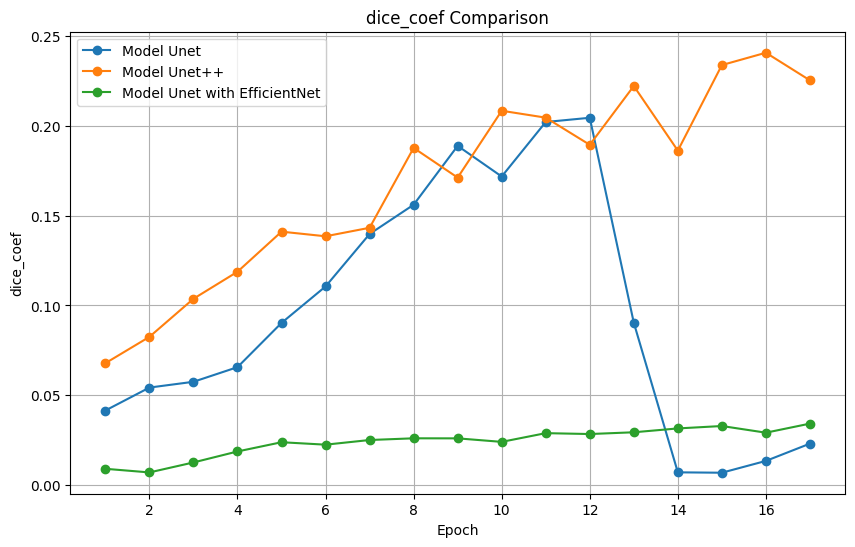

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have collected loss data for each model during training
epochs = range(1, 17 + 1)  # Replace num_epochs with the number of epochs trained
losses_model1 = history.history['dice_coef'][-17:]  # Loss values for model 1 for each epoch
losses_model2 = history_unetpp.history['dice_coef'][-17:]  # Loss values for model 2 for each epoch
losses_model3 = history_efficientNet.history['dice_coef'][-17:]  # Loss values for model 3 for each epoch

# Plotting loss comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_model1, label='Model Unet', marker='o')
plt.plot(epochs, losses_model2, label='Model Unet++', marker='o')
plt.plot(epochs, losses_model3, label='Model Unet with EfficientNet', marker='o')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.title('dice_coef Comparison')
plt.legend()
plt.grid(True)
plt.show()


### 3.2.2 Loss Comparison

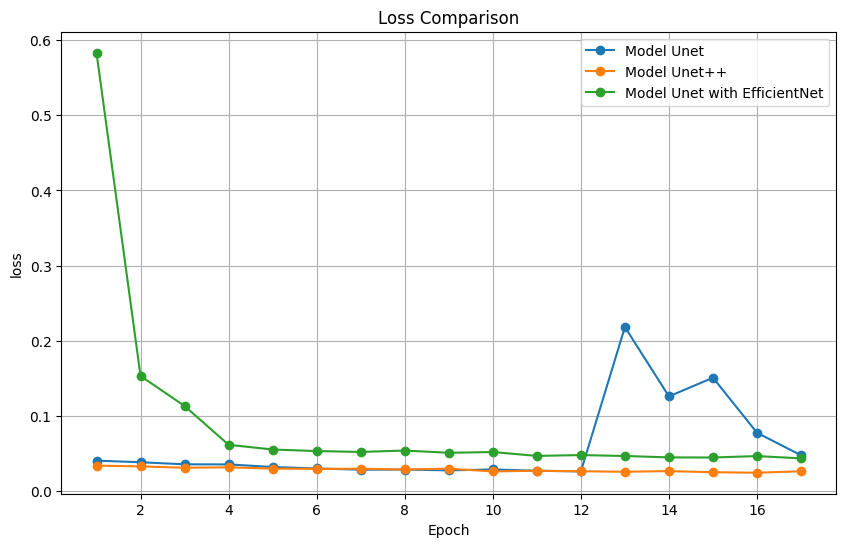

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have collected loss data for each model during training
epochs = range(1, 17 + 1)  # Replace num_epochs with the number of epochs trained
losses_model1 = history.history['loss'][-17:]  # Loss values for model 1 for each epoch
losses_model2 = history_unetpp.history['loss'][-17:]  # Loss values for model 2 for each epoch
losses_model3 = history_efficientNet.history['loss'][-17:]  # Loss values for model 3 for each epoch

# Plotting loss comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_model1, label='Model Unet', marker='o')
plt.plot(epochs, losses_model2, label='Model Unet++', marker='o')
plt.plot(epochs, losses_model3, label='Model Unet with EfficientNet', marker='o')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.title('Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


### 3.2.3 val_loss comparison

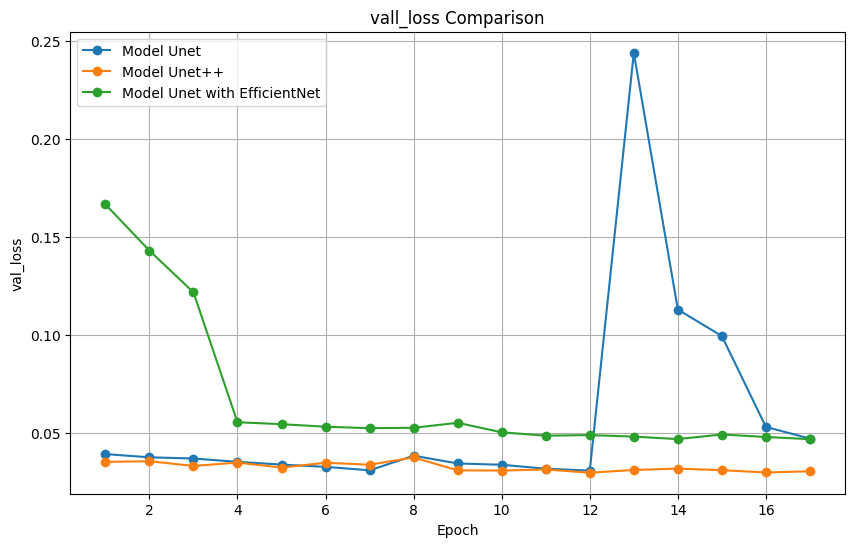

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have collected loss data for each model during training
epochs = range(1, 17 + 1)  # Replace num_epochs with the number of epochs trained
losses_model1 = history.history['val_loss'][-17:]  # Loss values for model 1 for each epoch
losses_model2 = history_unetpp.history['val_loss'][-17:]  # Loss values for model 2 for each epoch
losses_model3 = history_efficientNet.history['val_loss'][-17:]  # Loss values for model 3 for each epoch

# Plotting loss comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_model1, label='Model Unet', marker='o')
plt.plot(epochs, losses_model2, label='Model Unet++', marker='o')
plt.plot(epochs, losses_model3, label='Model Unet with EfficientNet', marker='o')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.title('vall_loss Comparison')
plt.legend()
plt.grid(True)
plt.show()


### 3.2.4 val_dice_coef comparison

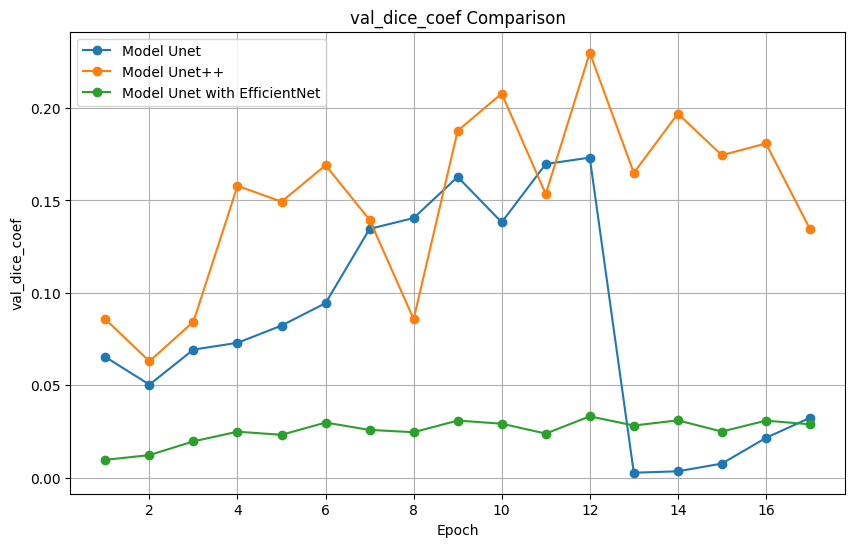

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have collected loss data for each model during training
epochs = range(1, 17 + 1)  # Replace num_epochs with the number of epochs trained
losses_model1 = history.history['val_dice_coef'][-17:]  # Loss values for model 1 for each epoch
losses_model2 = history_unetpp.history['val_dice_coef'][-17:]  # Loss values for model 2 for each epoch
losses_model3 = history_efficientNet.history['val_dice_coef'][-17:]  # Loss values for model 3 for each epoch

# Plotting loss comparison
plt.figure(figsize=(10, 6))
plt.plot(epochs, losses_model1, label='Model Unet', marker='o')
plt.plot(epochs, losses_model2, label='Model Unet++', marker='o')
plt.plot(epochs, losses_model3, label='Model Unet with EfficientNet', marker='o')
plt.xlabel('Epoch')
plt.ylabel('val_dice_coef')
plt.title('val_dice_coef Comparison')
plt.legend()
plt.grid(True)
plt.show()


### 3.3 Predicting on data with different models based input

In [ ]:
import cv2

def visualize_prediction(f: str,model_name):
    data_path = '/content/drive/MyDrive/NN_PROJECT/severstal-steel-defect-detection/train_images/'
    X = np.empty((1, 128, 800, 3), dtype='uint8')  # Adjust shape for RGB images
    img = cv2.imread(data_path + f)
    img = cv2.resize(img, (800, 128))
    # Convert grayscale image to 3-channel RGB image
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB if necessary
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_GRAY2RGB)  # Convert back to RGB

    X[0, ] = img_rgb  # Assign the RGB image to the input array

    mask = model_name

    df1 = train2[train2.ImageId == f].reset_index()
    if all((df1['e1'].all() == '', df1['e2'].all() == '', df1['e3'].all() == '', df1['e4'].all() == '')):

        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
        ax1.imshow(img)
        ax1.set_title(f)

        ax2.imshow(rle2mask(''))
        ax2.set_title('ground truth mask 0')

        ax3.imshow(mask[0, :, :, 0].round().astype('int'))
        ax3.set_title('predicted mask 0')
        plt.show()
        print('-' * 120, '\n')

    else:
        print(df1[f'e{1}'])
        print(df1[f'e{2}'])
        print(df1[f'e{3}'])
        print(df1[f'e{4}'])
        for k in [1, 2, 3, 4]:
            for i in range(len(df1)):
                if df1[f'e{k}'][i] != '':
                    encoded_pix = df1[f'e{k}'][i]

                    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 7))
                    ax1.imshow(img)
                    ax1.set_title(f)

                    ax2.imshow(rle2mask(encoded_pix))
                    ax2.set_title('ground truth mask ' + str(k))

                    ax3.imshow(rle2mask(encoded_pix))
                    ax3.set_title('predicted mask ' + str(k))
                    plt.show()
                    print('-' * 120, '\n')


0    0
Name: e1, dtype: object
0    0
Name: e2, dtype: object
0    0
Name: e3, dtype: object
0    243282 4 243537 12 243792 20 244046 29 244301 ...
Name: e4, dtype: object


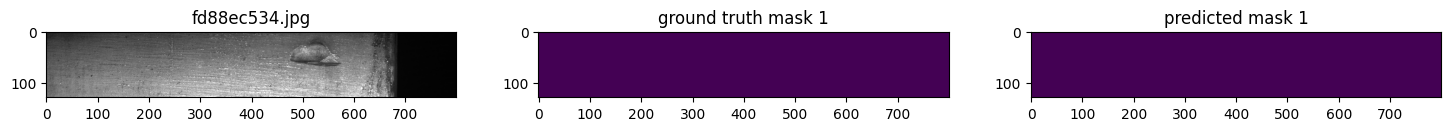

------------------------------------------------------------------------------------------------------------------------ 



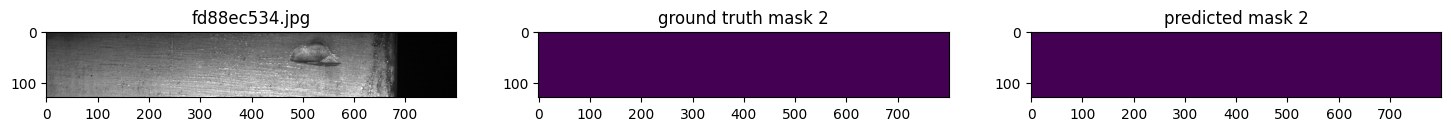

------------------------------------------------------------------------------------------------------------------------ 



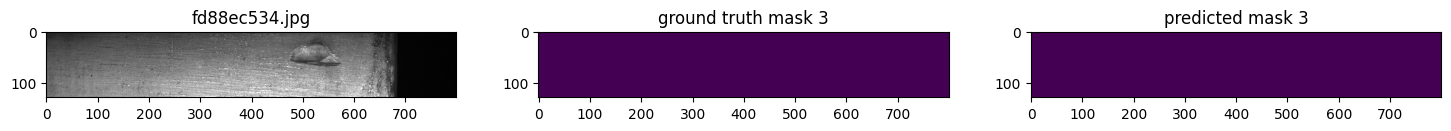

------------------------------------------------------------------------------------------------------------------------ 



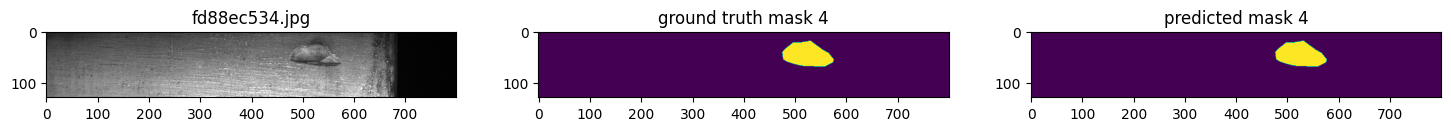

------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
visualize_prediction('fd88ec534.jpg',predictions_efficientNet)

0    0
Name: e1, dtype: object
0    0
Name: e2, dtype: object
0    0
Name: e3, dtype: object
0    326401 4 326658 9 326915 12 327172 13 327429 1...
Name: e4, dtype: object


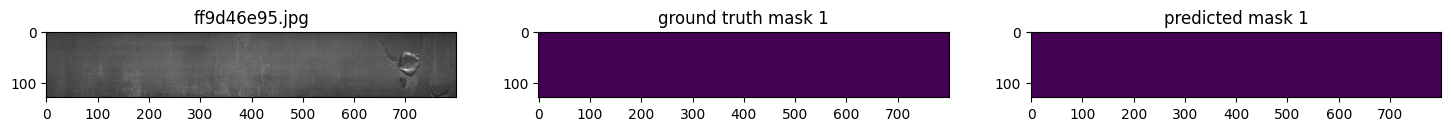

------------------------------------------------------------------------------------------------------------------------ 



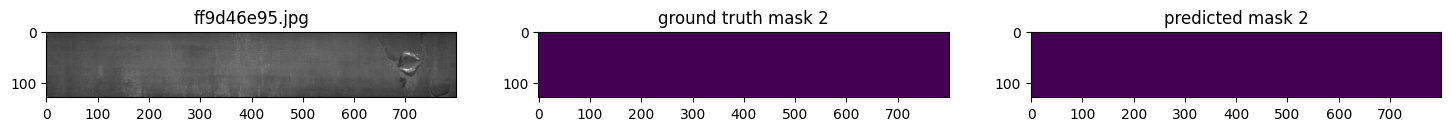

------------------------------------------------------------------------------------------------------------------------ 



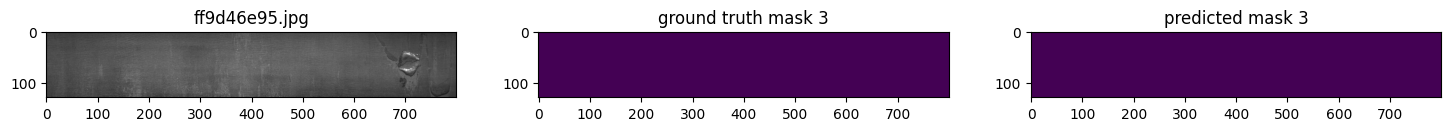

------------------------------------------------------------------------------------------------------------------------ 



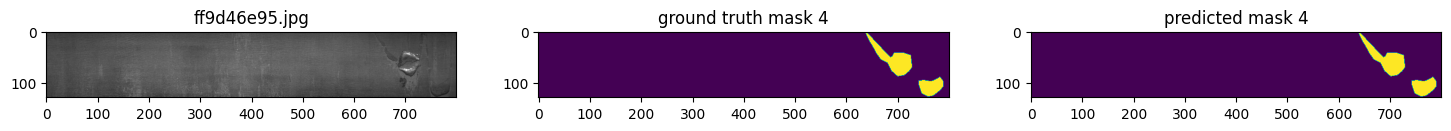

------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
visualize_prediction('ff9d46e95.jpg',predictions_unet)

0    356336 4 356587 11 356838 18 357089 25 357340 ...
Name: e1, dtype: object
0    375439 5 375687 14 375935 24 376182 34 376430 ...
Name: e2, dtype: object
0    0
Name: e3, dtype: object
0    0
Name: e4, dtype: object


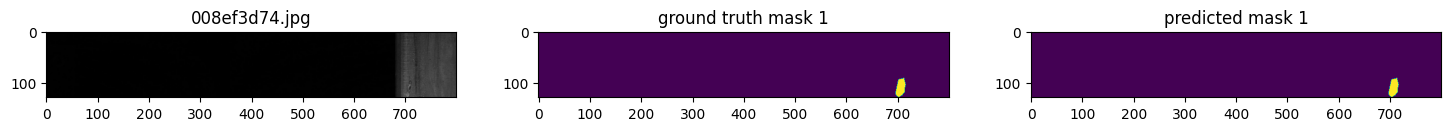

------------------------------------------------------------------------------------------------------------------------ 



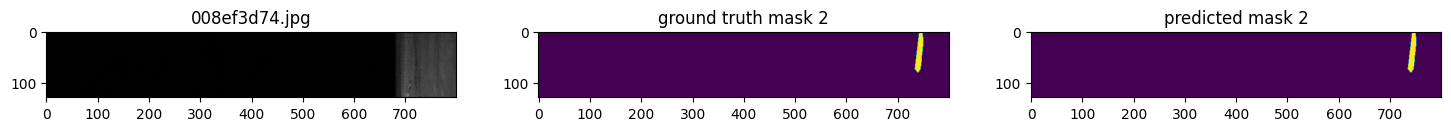

------------------------------------------------------------------------------------------------------------------------ 



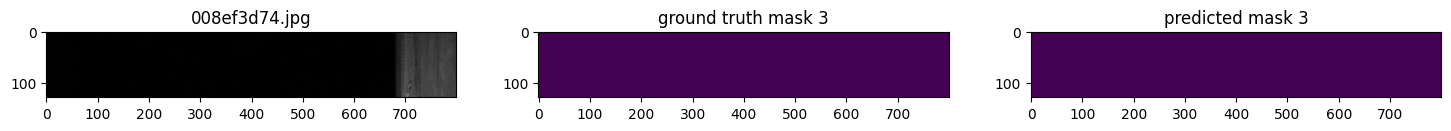

------------------------------------------------------------------------------------------------------------------------ 



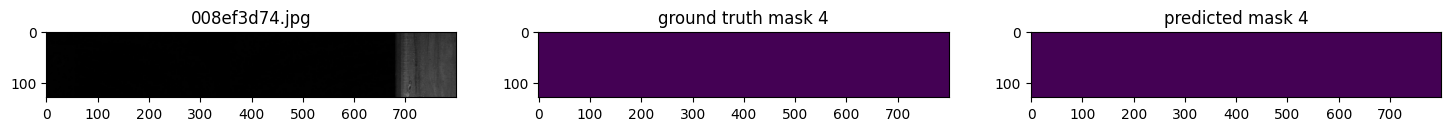

------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
visualize_prediction('008ef3d74.jpg',predictions_unetpp)

0    0
Name: e1, dtype: object
0    0
Name: e2, dtype: object
0    208 46 454 56 700 66 951 71 1207 71 1463 71 17...
Name: e3, dtype: object
0    0
Name: e4, dtype: object


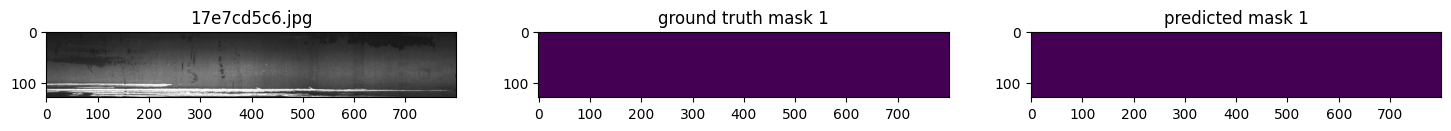

------------------------------------------------------------------------------------------------------------------------ 



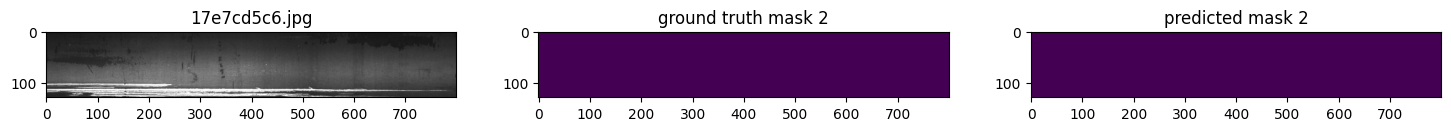

------------------------------------------------------------------------------------------------------------------------ 



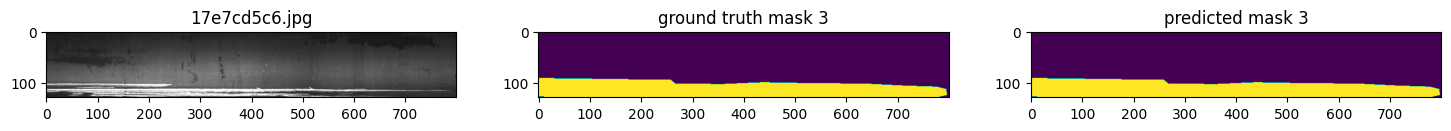

------------------------------------------------------------------------------------------------------------------------ 



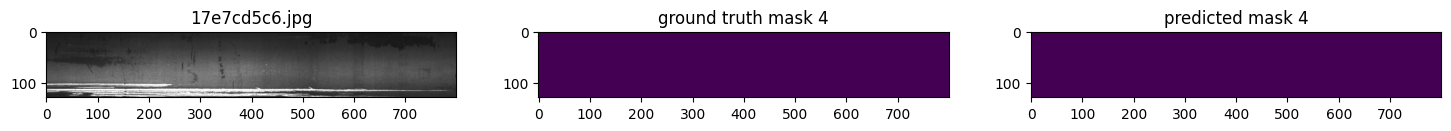

------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
visualize_prediction('17e7cd5c6.jpg',predictions_unetpp)

0    34635 47 34891 47 35147 47 35403 47 35659 47 3...
Name: e1, dtype: object
0    0
Name: e2, dtype: object
0    164 14 215 2 407 27 471 6 663 27 727 10 919 27...
Name: e3, dtype: object
0    0
Name: e4, dtype: object


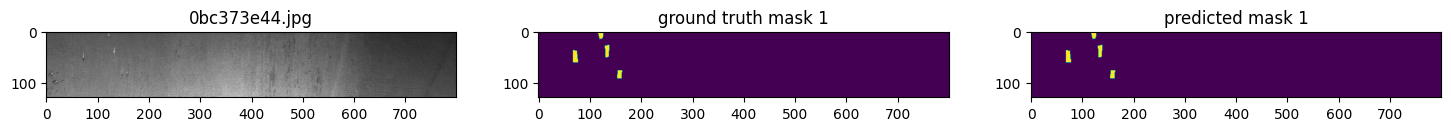

------------------------------------------------------------------------------------------------------------------------ 



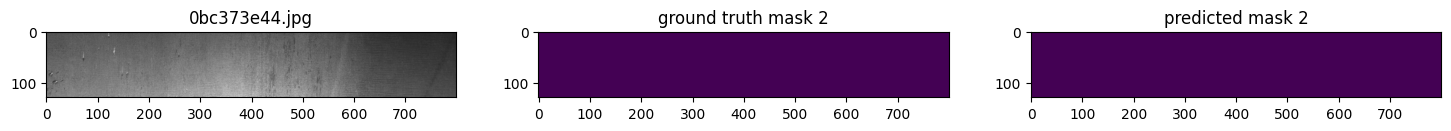

------------------------------------------------------------------------------------------------------------------------ 



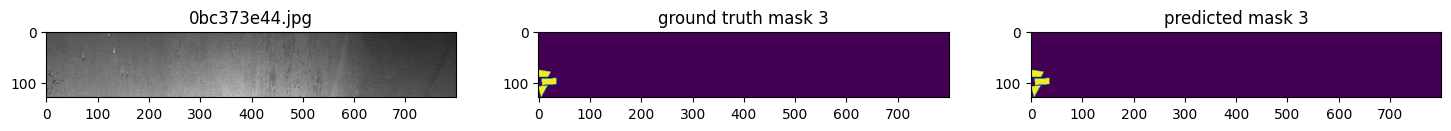

------------------------------------------------------------------------------------------------------------------------ 



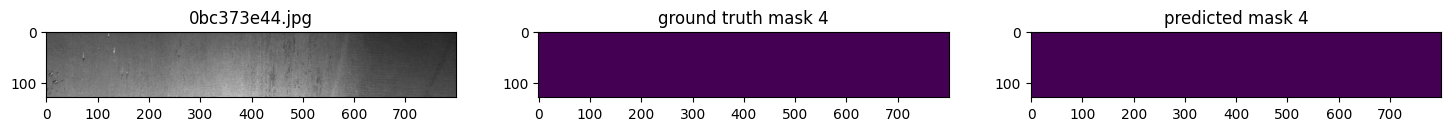

------------------------------------------------------------------------------------------------------------------------ 



In [ ]:
visualize_prediction('0bc373e44.jpg',predictions_unetpp)

## Thank You